In [1]:
import tensorflow as tf

import aux_code
import numpy as np

import os

import matplotlib.pyplot as plt
import pickle

2024-05-17 14:04:16.321988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Define folders

In [2]:
# Folder where the MLP weights are saved
model_folder           = os.path.join('.','model')
# Folder containing the dataset
dataset_folder = os.path.join('.','dataset')
# Folder where the quantized MLP weights will be saved
quantized_model_folder = os.path.join('.','quantized_model')
aux_code.create_folder(quantized_model_folder)
# Folder where the plots are saved
plots_folder = os.path.join('.','plots')
aux_code.create_folder(plots_folder)

# Quantized model weights

In [3]:
model = aux_code.define_mlp()
model.load_weights(os.path.join(model_folder, 'model_weights.h5'))

In [4]:
# Quantized weights
int_type = np.int32
SCALE    = 11

weightsI1 = model.trainable_variables[0].numpy()
bias1     = model.trainable_variables[1].numpy()
weights12 = model.trainable_variables[2].numpy()
bias2     = model.trainable_variables[3].numpy()
weights23 = model.trainable_variables[4].numpy()
bias3     = model.trainable_variables[5].numpy()
weights3O = model.trainable_variables[6].numpy()
biasO     = model.trainable_variables[7].numpy()


# Scale the weights by 2^SCALE
weightsI1 = (weightsI1 * (2 ** SCALE)).astype(int_type)
bias1 = (bias1 * (2 ** SCALE)).astype(int_type)
weights12 = (weights12 * (2 ** SCALE)).astype(int_type)
bias2 = (bias2 * (2 ** SCALE)).astype(int_type)
weights23 = (weights23 * (2 ** SCALE)).astype(int_type)
bias3 = (bias3 * (2 ** SCALE)).astype(int_type)
weights3O = (weights3O * (2 ** SCALE)).astype(int_type)
biasO = (biasO * (2 ** SCALE)).astype(int_type)

In [5]:
# Save quantized weights weights
np.save(os.path.join(quantized_model_folder, 'weightsI1'), weightsI1)
np.save(os.path.join(quantized_model_folder, 'bias1'), bias1)
np.save(os.path.join(quantized_model_folder, 'weights12'), weights12)
np.save(os.path.join(quantized_model_folder, 'bias2'), bias2)
np.save(os.path.join(quantized_model_folder, 'weights23'), weights23)
np.save(os.path.join(quantized_model_folder, 'bias3'), bias3)
np.save(os.path.join(quantized_model_folder, 'weights3O'), weights3O)
np.save(os.path.join(quantized_model_folder, 'biasO'), biasO)

# Load and normalize test set

In [6]:
test_set = np.load(os.path.join(dataset_folder, 'test_set.npz'))
x_test = aux_code.normalize_quantized_dataset(test_set['nn_data_test'].astype(int_type), SCALE=SCALE)
y_test = test_set['stx_flare_loc_test']
cfl_loc_test = test_set['cfl_loc_test']

# Quantized MLP predictions on the test set

In [7]:
y_pred_q = np.zeros((len(x_test),2), dtype=np.int16)
y_nn_norm_factor=4000

for i in range(len(x_test)):
    
    this_out = aux_code.quantized_nn_model(x_test[i,:], weightsI1, bias1, weights12, bias2, weights23, bias3, 
                                           weights3O, biasO, SCALE = SCALE)
    y_pred_q[i,:] = (this_out * y_nn_norm_factor + 2**(SCALE-1)) >> SCALE

# Comparison between quantized MLP and CFL algorithm

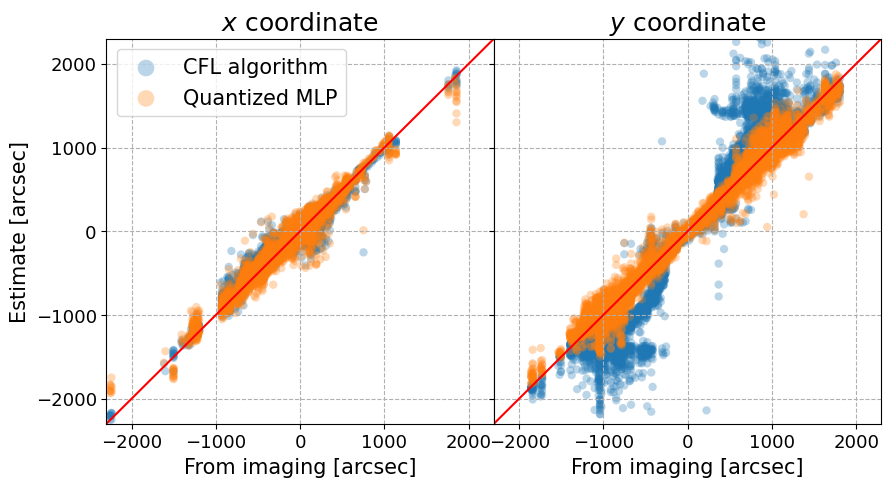

In [8]:
# Plot results
xy_min_max = 2300

legsize=15
labelsize=15
ticksize=13
titlesize=18

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))#, gridspec_kw={'height_ratios': [2, 1]}
fig.subplots_adjust(wspace=0)

axs[0].scatter(y_test[:,0],cfl_loc_test[:,0], alpha=0.3, label='CFL algorithm', edgecolors='none')
axs[0].scatter(y_test[:,0],y_pred_q[:,0], alpha=0.3, label='Quantized MLP', edgecolors='none')
axs[0].set_xlim(-xy_min_max, xy_min_max)
axs[0].set_ylim(-xy_min_max, xy_min_max)
axs[0].plot([-xy_min_max,xy_min_max],[-xy_min_max,xy_min_max], color='r')

axs[0].set(title='$x$ coordinate')
axs[0].title.set_size(titlesize)
axs[0].xaxis.label.set_size(labelsize)
axs[0].yaxis.label.set_size(labelsize)
axs[0].tick_params(axis="x", labelsize=ticksize)
axs[0].tick_params(axis="y", labelsize=ticksize)
axs[0].set(xlabel='From imaging [arcsec]')
axs[0].set(ylabel='Estimate [arcsec]')
axs[0].grid(linestyle='--')

axs[0].legend(loc="upper left", fontsize=legsize, markerscale=2)

axs[1].scatter(y_test[:,1],cfl_loc_test[:,1], alpha=0.3, label='CFL algorithm', edgecolors='none')
axs[1].scatter(y_test[:,1],y_pred_q[:,1], alpha=0.3, label='Quantized MLP', edgecolors='none')
axs[1].set_xlim(-xy_min_max, xy_min_max)
axs[1].set_ylim(-xy_min_max, xy_min_max)
axs[1].plot([-xy_min_max,xy_min_max],[-xy_min_max,xy_min_max], color='r')

axs[1].set(title='$y$ coordinate')
axs[1].title.set_size(titlesize)
axs[1].xaxis.label.set_size(labelsize)
axs[1].yaxis.label.set_size(labelsize)
axs[1].tick_params(axis="x", labelsize=ticksize)
axs[1].tick_params(axis="y", labelsize=ticksize)
axs[1].set(xlabel='From imaging [arcsec]')
axs[1].grid(linestyle='--')

plt.savefig(os.path.join(plots_folder, 'predictions_quantized_weights.png'), bbox_inches='tight', dpi=300)

plt.show()

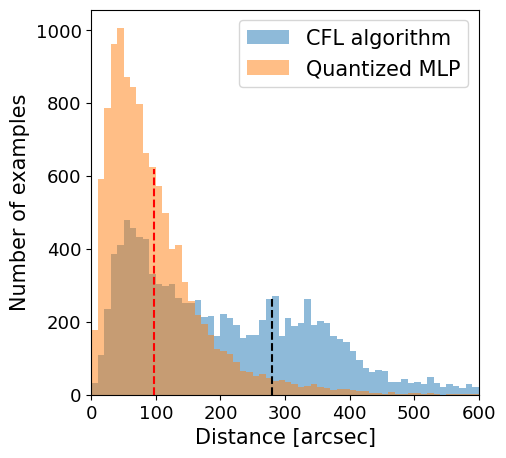

In [11]:
dist_nn_q  = np.sqrt( (y_test[:,0]-y_pred_q[:,0])**2 + (y_test[:,1]-y_pred_q[:,1])**2 )
dist_cfl = np.sqrt( (y_test[:,0]-cfl_loc_test[:,0])**2 + (y_test[:,1]-cfl_loc_test[:,1])**2 )

mean_dist_nn_q = np.mean(dist_nn_q)
mean_dist_cfl  = np.mean(dist_cfl)

bins = np.linspace(0, 1000, num=101)

plt.figure(figsize=(5, 5))

legsize=15
labelsize=15
ticksize=13
titlesize=18

plt.hist(dist_cfl,bins=bins, alpha=0.5,label='CFL algorithm')
plt.hist(dist_nn_q,bins=bins,alpha=0.5,label='Quantized MLP')

plt.plot([mean_dist_nn_q,mean_dist_nn_q],[0,620], 'r--')
plt.plot([mean_dist_cfl,mean_dist_cfl],[0,270], 'k--')

plt.xlim(0,600)
plt.legend(loc="upper right")
#plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=labelsize)   # fontsize of the axes title
plt.rc('axes', labelsize=labelsize)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=ticksize)  # fontsize of the tick labels
plt.rc('ytick', labelsize=ticksize)  # fontsize of the tick labels
plt.rc('legend', fontsize=legsize)  # legend fontsize

plt.xlabel("Distance [arcsec]")
plt.ylabel("Number of examples")

plt.savefig(os.path.join(plots_folder, 'hist_dist_nn_q.png'), bbox_inches='tight', dpi=300)

plt.show()